In [26]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='best.pt') 

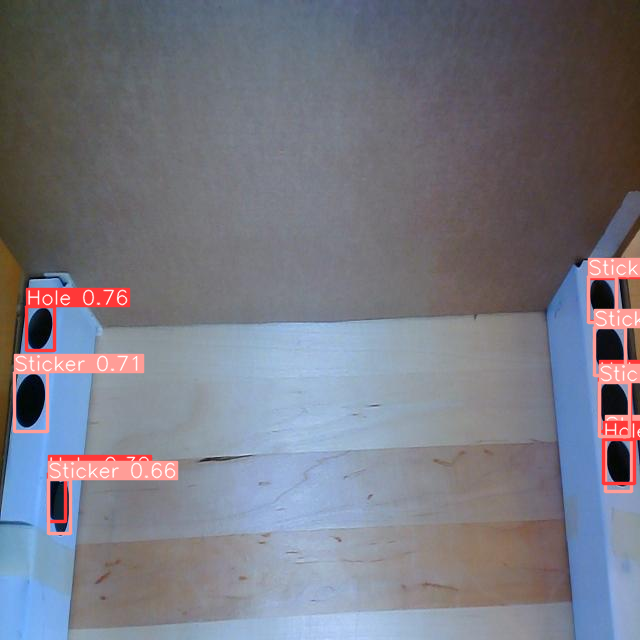

In [98]:
# Image
img = r"C:\Users\markd\Documents\GitHub\ToyotaChallenge2023\train_data\valid\images\White_12_jpg.rf.dc04713e804e6186c99c0584efe4f3fb.jpg"
# Inference
results = model(img)
results.show()

In [104]:
def iou(center1,width1 , height1, center2, width2, height2):
    """
    Input: 
        center 1 - (x, y) center position of box 1
        width 1 - width of first box
        height 1 - height of first box
        center2 -- tuple representing the center point of the second box in the format (x2, y2)
        width2 -- width of the second box
        height2 -- height of the second box

        Outputs: IOU value of bounding boxes
    """
    # Calculate the coordinates of the first bounding box
    x1 = center1[0] - (width1 / 2)
    y1 = center1[1] - (height1 / 2)
    x2 = center1[0] + (width1 / 2)
    y2 = center1[1] + (height1 / 2)

    # Calculate the coordinates of the second bounding box
    x3 = center2[0] - (width2 / 2)
    y3 = center2[1] - (height2 / 2)
    x4 = center2[0] + (width2 / 2)
    y4 = center2[1] + (height2 / 2)

    # Calculate the coordinates of the intersection rectangle
    x5 = max(x1, x3)
    y5 = max(y1, y3)
    x6 = min(x2, x4)
    y6 = min(y2, y4)

     # Calculate the area of intersection rectangle
    intersection_area = max(0, x6 - x5) * max(0, y6 - y5)

    # Calculate the area of both bounding boxes
    box1_area = width1 * height1
    box2_area = width2 * height2

    # Calculate the IOU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou

In [118]:
import math
# Calculate distance function
def calc_dist(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Get results array
r = results.xywh[0].numpy()
num_boxes = r.shape[0]
pair_tracker = []
bad_index = set()
taken = set()
error_index = set()
outputs = [i for i in range(num_boxes)]

# Looping through bounding boxes
for i in range(num_boxes):
    if r[i][4] < 0.4:
        bad_index.add(i)
        continue

    if i in bad_index:
        continue

    dist_tracker = [10,0] # (distance, #index of second box that is close by)
    # Looping through remaining boxes
    for k in range(num_boxes):
        if r[k][4] < 0.4:
            bad_index.add(k)
            continue
        if k in bad_index:
            continue
        if i != k and r[i][5] != r[k][5]:
            # Get distance
            new_dist = calc_dist(r[i][0], r[i][1], r[k][0], r[k][1])
            if dist_tracker[0] > new_dist:
                dist_tracker[0] = new_dist
                dist_tracker[1] = k 
                

    # Append pair of different labels to output list
    if dist_tracker[1] != 0 and i not in taken and k not in taken:
        pair_tracker.append([i, dist_tracker[1]])
        taken.add(i)
        taken.add(dist_tracker[1])
        
print(pair_tracker)

# Check overlap
for pairs in pair_tracker:
    x1, y1, w1, h1, _, _ = r[pairs[0]]
    x2, y2, w2, h2, _, _ = r[pairs[1]]
    print(iou((x1, y1), w1, h1, (x2, y2), w2, h2))
    if iou((x1, y1), w1, h1, (x2, y2), w2, h2) < 0.8:
        bad_index.add(pairs[0])
        error_index.add(pairs[1])
    else: # same overlap
        # take pair with higher prediction
        if r[pairs[0]][4] > r[pairs[1]][4]:
            bad_index.add(pairs[1])
        else:
            bad_index.add(pairs[0])

# Making list output
print(len(outputs))
for i in range(len(outputs)):
    if outputs[i] in bad_index:
        print('set non')
        outputs[i] = 'non'
    elif outputs[i] in error_index:
        print('set error')
        outputs[i] = 'error_index'
    else:
        class_name = r[outputs[i]][5]
        print('set labelname')
        if class_name == 1.0:
            outputs[i] = 'sticker'
        else:
            outputs[i] = 'hole'

outputs
#sticker, hole, non, defect

[[1, 7], [6, 8]]
0.8070134007119485
0.6596314898296669
11
set labelname
set labelname
set labelname
set labelname
set labelname
set labelname
set non
set non
set error
set non
set non


['hole',
 'sticker',
 'sticker',
 'sticker',
 'sticker',
 'sticker',
 'non',
 'non',
 'error_index',
 'non',
 'non']

In [119]:
for box in results.xywh[0]:
    print(f'x: {box[0]}, y: {box[1]}, w: {box[2]}, h: {box[3]}, confidence: {box[4]}, class: {box[5]} ')

x: 40.49851608276367, y: 328.92578125, w: 27.29006004333496, h: 43.8994140625, confidence: 0.7614014148712158, class: 0.0 
x: 614.8239135742188, y: 409.4751892089844, w: 29.98046875, h: 53.95361328125, confidence: 0.7233995199203491, class: 1.0 
x: 31.111982345581055, y: 402.01611328125, w: 33.15178298950195, h: 58.29052734375, confidence: 0.7144473791122437, class: 1.0 
x: 59.381324768066406, y: 506.7445068359375, w: 21.252033233642578, h: 53.509735107421875, confidence: 0.6567356586456299, class: 1.0 
x: 609.650146484375, y: 351.48236083984375, w: 31.06494140625, h: 47.8465576171875, confidence: 0.6093225479125977, class: 1.0 
x: 602.5012817382812, y: 299.4140319824219, w: 27.6187744140625, h: 45.53887939453125, confidence: 0.6035565137863159, class: 1.0 
x: 618.7879638671875, y: 461.6837463378906, w: 30.8753662109375, h: 43.70587158203125, confidence: 0.5701306462287903, class: 0.0 
x: 614.9766235351562, y: 404.6580810546875, w: 31.1048583984375, h: 52.8245849609375, confidence: 0.5

In [39]:
frame = cv2.imread(r"C:\Users\markd\Documents\GitHub\ToyotaChallenge2023\train_data\valid\images\10_some_holes_covered-1-_jpg.rf.06e72377c1499dfbf96d57b6e1a01d00.jpg", cv2.IMREAD_COLOR)

<class 'numpy.ndarray'>


In [ ]:
frame = np.expand_dims(frame, axis=0)
frame.shape

In [51]:
x = torch.Tensor([1])
x = x.numpy()
x

array([          1], dtype=float32)

In [52]:
x = [79]
x

[79]